# Привет!

Это уже версия 100500. В ней я уже е стал сильно заморачиватся с отображением картинок и больше сконцентрировался на алгоритмах. Что в общем то дало хорошие плоды. Если останется немного времени - обязательно добавлю визуализации, если их не будет, увы - значит не успел. Спасибо за внимание и приятного изучения.

# 1.1 Загружаем основные библиотеки для исследования и обучения

In [1]:
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.feature import local_binary_pattern

import os
import gc

**У нас есть:**

* Папка с картинками train и метки по размытию этих картинок в train.csv, тоесть файлы для тренировки модели
* Папка с картинками test над которой мы и будем проводить эксперимент
* Пример вывода в виде sample_submission.csv

Утилита для отображения загрузки RAM. Что бы можно было удобно отслеживатьзагрузку памяти.

In [2]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

# 1.2 Подготовим сет для анализа

In [3]:
train_images_labels = pd.read_csv('/kaggle/input/shift-cv-winter-2023/train.csv', header=0)
train_images_labels['blur'] = pd.to_numeric(train_images_labels['blur'].astype(int), downcast='integer')


# Загрузка изображений из CSV файла
def load_images(data_frame, image_dir):
    images = []
    labels = []
    #dim = (420,420)
    for idx, data in enumerate(data_frame['filename']):
        filename, label = data_frame.iloc[idx,0], data_frame.iloc[idx,1]
        filepath = f'{image_dir}/{filename}'
        image = cv2.imread(filepath)
        #resized = cv2.resize(image, dim, interpolation = cv2.INTER_AREA)
        #rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        grayimg = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        images.append(grayimg)
        labels.append(int(label))
        
        print(idx+1,' of ' ,len(data_frame['filename']), " | ", filename + ': ', image.shape, label.shape, end='\r')
    return images, labels


# Загрузка изображений и меток
train_images_direct = '/kaggle/input/shift-cv-winter-2023/train/train'
images_train, labels_train = load_images(train_images_labels[:800], train_images_direct) 

Посмотрим на сет

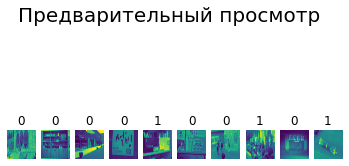

In [4]:
batch_size=10

for i in range(batch_size):
    plt.subplot(1, batch_size, i + 1)
    img = images_train[i]
    img = img / 255
    plt.imshow(img)
    plt.axis('off')
    # Указать размытость
    plt.title(labels_train[i])

plt.suptitle('Предварительный просмотр', size=20)
plt.show()


In [5]:
# Удалим все лишнее
del img
gc.collect()

# Диспетчер переменных, проверим, все ли удалили
for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

           train_images_labels: 213.5 KiB
                  images_train:  6.9 KiB
                  labels_train:  6.9 KiB
                           _ii:  2.3 KiB
                           _i3:  2.3 KiB
                            _i:  642.0 B
                           _i4:  642.0 B
                           _i5:  610.0 B
                          _iii:  382.0 B
                           _i2:  382.0 B


In [6]:
# Подготовим метки
labels = np.asarray(labels_train)

# 2.1 Подготовим функции для анализа изображений

In [7]:
# Функция Лапласа для извлечения признаков
def lap_features(image):
    lap = cv2.Laplacian(image, cv2.CV_64F) #.astype(np.float32)
    lap = np.abs(lap)
    lap = lap.flatten()
    return lap

# Функция Фурье для извлечения признаков
def fourier_features(image):
    fft = np.abs(np.fft.fft2(image))
    fft = fft.flatten()
    return fft

# Функция DCT для извлечения признаков
def dct_features(image):
    dct = cv2.dct(image.astype(np.float32))
    dct = np.abs(dct)
    dct = dct.flatten()
    return dct

# Функция LBP для извлечения признаков
def lbp_features(image):
    lbp = local_binary_pattern(image, 8, 1, 'uniform')
    lbp = lbp.flatten()
    return lbp

# 2.2 Используя функции соберем сет для тренировки и проверки

In [8]:
lap_data = np.array([lap_features(image) for image in images_train])
fou_data = np.array([fourier_features(image) for image in images_train])
dct_data = np.array([dct_features(image) for image in images_train])
lbp_data = np.array([lbp_features(image) for image in images_train])
                          
# Объединение признаков в единый массив
features = np.concatenate([lap_data, fou_data, dct_data, lbp_data], axis=1)

(lap_data.shape, fou_data.shape, dct_data.shape, lbp_data.shape)

((800, 409600), (800, 409600), (800, 409600), (800, 409600))

In [9]:
# Удалим все лишнее
del images_train, labels_train, lap_data, fou_data, dct_data, lbp_data, train_images_labels
gc.collect()

# Диспетчер переменных, проверим, все ли удалили
for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                      features:  9.8 GiB
                        labels:  6.4 KiB
                           _i3:  2.3 KiB
                           _ii:  1.4 KiB
                           _i7:  1.4 KiB
                            _i:  1.0 KiB
                           _i8:  1.0 KiB
                           _i9:  778.0 B
                           _i4:  642.0 B
                           _i5:  610.0 B


In [10]:
# Проверим типы и структуру
(labels.dtype, features.dtype), (labels.shape, features.shape)

((dtype('int64'), dtype('float64')), ((800,), (800, 1638400)))

In [11]:
# Подготовим размер для модели
model_shape = features.shape[1]
model_shape

1638400

In [12]:
from sklearn.model_selection import train_test_split

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(features, np.asarray(labels), test_size=0.2)

In [13]:
# Удалим все лишнее
del features, labels
gc.collect()

# Диспетчер переменных, проверим, все ли удалили
for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                       X_train:  7.8 GiB
                        X_test:  2.0 GiB
                       y_train:  5.1 KiB
                           _i3:  2.3 KiB
                           _i7:  1.4 KiB
                        y_test:  1.4 KiB
                           _i8:  1.0 KiB
                           _i9:  778.0 B
                           _i4:  642.0 B
                          _i13:  636.0 B


# 3.1 Теперь попробуем обучить модель на этих полученных данных


In [14]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((640, 1638400), (160, 1638400), (640,), (160,))

In [15]:
model = tf.keras.Sequential([
tf.keras.layers.Dense(128, activation='relu', input_shape=(model_shape,)),
tf.keras.layers.Dense(64, activation='relu'),
tf.keras.layers.Dense(32, activation='relu'),
tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=31, validation_data=(X_test, y_test))

2023-01-08 23:59:20.314272: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2023-01-08 23:59:35.364553: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/31
20/20 [==============================] - 18s 747ms/step - loss: 165036.6250 - accuracy: 0.6719 - val_loss: 16116.8877 - val_accuracy: 0.8938
Epoch 2/31
20/20 [==============================] - 14s 686ms/step - loss: 20697.2852 - accuracy: 0.8578 - val_loss: 11455.4980 - val_accuracy: 0.9000
Epoch 3/31
20/20 [==============================] - 13s 671ms/step - loss: 11512.4180 - accuracy: 0.9078 - val_loss: 8079.6396 - val_accuracy: 0.9250
Epoch 4/31
20/20 [==============================] - 14s 692ms/step - loss: 4906.2812 - accuracy: 0.9422 - val_loss: 4374.8755 - val_accuracy: 0.9312
Epoch 5/31
20/20 [==============================] - 13s 672ms/step - loss: 1542.9851 - accuracy: 0.9734 - val_loss: 3951.2825 - val_accuracy: 0.9438
Epoch 6/31
20/20 [==============================] - 14s 695ms/step - loss: 727.3300 - accuracy: 0.9750 - val_loss: 3213.6890 - val_accuracy: 0.9375
Epoch 7/31
20/20 [==============================] - 13s 671ms/step - loss: 1034.3972 - accuracy: 0.97

In [16]:
# Оценка точности модели
_, accuracy = model.evaluate(X_test, y_test)
print(f'Accuracy: {accuracy:.2f}')

5/5 [==============================] - 1s 177ms/step - loss: 6639.2124 - accuracy: 0.9500
Accuracy: 0.95


In [17]:
# Удалим все лишнее
del X_train, X_test, y_train, y_test
gc.collect()

# Диспетчер переменных, проверим, все ли удалили
for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                           _i3:  2.3 KiB
                           _i7:  1.4 KiB
                           _i8:  1.0 KiB
                           _i9:  778.0 B
                          _i17:  668.0 B
                           _i4:  642.0 B
                          _i13:  636.0 B
                           _i5:  610.0 B
                          _i12:  478.0 B
                           _ii:  450.0 B


# 3.2 Подготовим сет для проверки нашей модели на предоставленных тестовых данных

In [18]:
test_images_direct = '/kaggle/input/shift-cv-winter-2023/test/test'

test_images_labels = pd.DataFrame()
test_images_labels['filename'] = pd.DataFrame(os.listdir(test_images_direct))
test_images_labels['blur'] = pd.to_numeric(int(2), downcast='integer')


images_test, labels_test = load_images(test_images_labels, test_images_direct)

In [19]:
lap_data_pred = np.array([lap_features(image_test) for image_test in images_test])
fou_data_pred = np.array([fourier_features(image_test) for image_test in images_test])
dct_data_pred = np.array([dct_features(image_test) for image_test in images_test])
lbp_data_pred = np.array([lbp_features(image_test) for image_test in images_test])

# Объединение признаков в единый массив
features_pred = np.concatenate([lap_data_pred, fou_data_pred, dct_data_pred, lbp_data_pred], axis=1)

In [20]:
# Удалим все лишнее
del lap_data_pred, fou_data_pred, dct_data_pred, lbp_data_pred
gc.collect()

# Диспетчер переменных, проверим, все ли удалили
for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                 features_pred:  9.4 GiB
            test_images_labels: 67.4 KiB
                   images_test:  6.9 KiB
                   labels_test:  6.9 KiB
                           _i3:  2.3 KiB
                           _i7:  1.4 KiB
                           _i8:  1.0 KiB
                            _i:  1.0 KiB
                          _i19:  1.0 KiB
                           _i9:  778.0 B


# 3.3 Тестируем модель на неизвестных предоставленных данных

In [21]:
pred = model.predict(features_pred).astype(np.int8)

# 4.1 Теперь записываем данные для отправки

In [22]:
test_images_labels['blur'] = pred
test_images_labels.to_csv('kamuz_bogdan_moscow_submission.csv', index=False)